<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/PetBreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 6.6 MB/s 
     |████████████████████████████████| 1.2 MB 50.9 MB/s 
     |████████████████████████████████| 346 kB 64.7 MB/s 
     |████████████████████████████████| 197 kB 45.6 MB/s 
     |████████████████████████████████| 4.2 MB 36.7 MB/s 
     |████████████████████████████████| 59 kB 8.0 MB/s 
     |████████████████████████████████| 212 kB 40.0 MB/s 
     |████████████████████████████████| 140 kB 40.2 MB/s 
     |████████████████████████████████| 86 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
     |████████████████████████████████| 127 kB 72.5 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 71.4 MB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 
     |████████████████████████████████| 6.6 MB 35.0 MB/s 
ERROR: pip's dependency

In [2]:
#Load Data
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

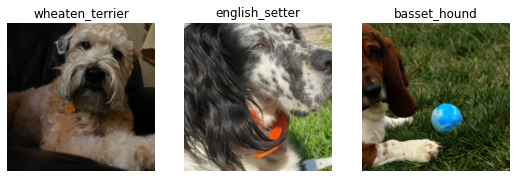

In [3]:
#We aren't doing localization so we can ignore annotations
fname = (path/"images").ls()[0]
#Use regex to label dataset
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),  #Types of data
                 get_items = get_image_files, #How to get items
                 splitter = RandomSplitter(seed=42),  #Split into train and test sets
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),  #Get labels
                 item_tfms = Resize(460), #presizing, resize image larger than final target to help avoid data loss
                 batch_tfms = aug_transforms(size=224, min_scale=.75)) #set final soze smaller than presize and do aug transforms
dls = pets.dataloaders(path/"images") #load with above settings

#Check our data
dls.show_batch(nrows=1, ncols=3)

In [4]:
#Make a simple model
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.538923,0.291569,0.089310,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.492244,0.262458,0.084574,01:20
1,0.325120,0.197374,0.060217,01:20


In [5]:
acts = torch.randn((6,2))*2 #Random activations (predictions) for softmax example
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
sm_acts = torch.softmax(acts, dim=1) #Take the returned activations and put them in the sigmoid function
sm_acts

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

##Log Likelihood: A more flexible loss function that uses the softmax calculated above. Our new goal is to maximize the activation for the correct label - and because softmax makes all activations sum to 1, this also lowers the activation values of all incorrect labels. 

In [8]:
#Example of Log Likelihood
targ = tensor([1,1,1,0,1,0]) #Target labels, 0=3s 1=7s
idx = range(6)
sm_acts[idx, targ] #For each target returns the softmax activation value of the given label, we want to maximize this sum

tensor([0.9827, 0.9346, 0.9266, 0.2011, 0.1541, 0.9867])

In [9]:
#Pytorch provides a function for this
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.9827, -0.9346, -0.9266, -0.2011, -0.1541, -0.9867])

In [10]:
#We want to transform our prediction values to be in (-infinity, infinity) not (0,1)
#This will help better identify changes in the loss
#To do his we use the log function
loss_func = nn.CrossEntropyLoss() #Gets softmax then log likelihood
loss_func(acts, targ) #Notice it returns the mean, turn off with param reduction='none'

tensor(0.6082)

In [11]:
#Also available in function form
F.cross_entropy(acts, targ)

tensor(0.6082)

##Interpreting our Model

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=5) #Show which classes have most incorrect predictions, we can see it's confusing very related breeds

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Egyptian_Mau', 'Bengal', 7)]